In [1]:
import sys
sys.path.append("../../")

In [3]:
import torch
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.test_functions.multi_objective import VehicleSafety, DTLZ2
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [5]:
# define problem
problem = DTLZ2(negate=True, dim=4, num_objectives=3).to(**tkwargs)

In [6]:
def generate_initial_data(problem, n=12):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds, n=n, q=1).squeeze(1)
    train_obj = problem(train_x)
    return train_x, train_obj

In [56]:
init_x, init_y = generate_initial_data(problem, n=100)
x_obs = init_x
y_obs = init_y

In [57]:
bd = DominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
nbd = FastNondominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)

u_pareto, pareto = bd.hypercell_bounds
ndom, _ = nbd.hypercell_bounds
is_pareto = is_non_dominated(y_obs)

In [60]:
pareto[0]

tensor([-0.3109, -1.0709, -0.1296], dtype=torch.float64)

In [62]:
u_pareto[0]

tensor([-1.1000, -1.1000, -0.2288], dtype=torch.float64)

In [59]:
ndom.shape

torch.Size([103, 3])

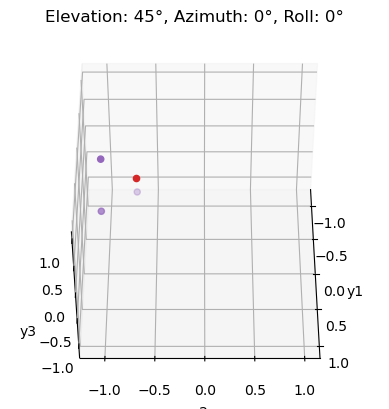

In [50]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(y_obs[~is_pareto][:, 0], y_obs[~is_pareto][:, 1], y_obs[~is_pareto][:, 2], label="observed", alpha=0.5);
ax.scatter(pareto[:, 0], pareto[:, 1], pareto[:, 2], label="pareto", color="tab:red");
ax.scatter(ndom[:, 0], ndom[:, 1], ndom[:, 2], label="non dominated", color="tab:purple");
ax.set_xlabel('y1')
ax.set_ylabel('y2')
ax.set_zlabel('y3')

# Rotate the axes and update
angle = 45
# Normalize the angle to the range [-180, 180] for display
angle_norm = (angle + 180) % 360 - 180

# Cycle through a full rotation of elevation, then azimuth, roll, and all
elev = azim = roll = 0
if angle <= 360:
    elev = angle_norm
elif angle <= 360*2:
    azim = angle_norm
elif angle <= 360*3:
    roll = angle_norm
else:
    elev = azim = roll = angle_norm

# Update the axis view and title
ax.view_init(elev, azim, roll)
plt.title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))

plt.draw()